# K- Nearest Neighbors on Amazon Food Reviews

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# General Packages
import os
import sqlite3
import pandas as pd
import numpy as np
import string
import re
import nltk
import datetime
import time

# Plotting Packages
import matplotlib.pyplot as plt
import seaborn as sns

# Packages for Tfidf
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

# Packages for BOW (Bag of words)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

# Packages for Text Preprocessing
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

#Packages for Word2vec, Average Word2vec & Tf-Idf Weighted Word2Vec
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

#Packages for plotting Tsne plot
from sklearn.manifold import TSNE

from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.model_selection import TimeSeriesSplit

/usr/lib/python3/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Preprocessing Stage: Cleansed Stop Words, Punctuations & Html tags

In [2]:
#Connecting the Sqlite file after the Preprocessing Stage
#os.chdir('/Users/sujis/Downloads/AI')
con2 = sqlite3.connect('final.sqlite') 
final= pd.read_sql_query(""" SELECT * FROM Reviews """, con2) 

In [3]:
final.head(1)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...


In [4]:
# Due to memory constraints taking 2.5k positive & 2.5k negative reviews
final_dataset=pd.DataFrame()
positive_dataset=final.loc[final['Score'] == 'positive'].head(2500)
Negative_dataset=final.loc[final['Score'] == 'negative'].head(2500)
final_dataset=pd.concat([positive_dataset,Negative_dataset])
l1 = positive_dataset['Score']
l2 = Negative_dataset['Score']
label=pd.concat([l1,l2])

In [5]:
# Converting the Epoch Date format to normal date format
Time_P=[]
Time_N=[]
for each in positive_dataset['Time']:
    Time_P.append(time.strftime('%Y-%m-%d', time.localtime(each)))
for each in Negative_dataset['Time']:
    Time_N.append(time.strftime('%Y-%m-%d', time.localtime(each)))
Time=Time_P+Time_N

In [6]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(final_dataset['CleanedText'].values)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (5000, 10430)
the number of unique words  10430


In [8]:
# Converting Sparse matric to array
final_counts=final_counts.toarray()

In [9]:
#tsne
start_time_code = time.time()
model = TSNE(n_components=2, random_state=0, perplexity=30)
tsne_data = model.fit_transform(final_counts)
end_time_code = time.time()
print ("Running Time for code execution " + str(end_time_code - start_time_code) + " secs")

Running Time for code execution 592.2491195201874 secs


In [10]:
tsne_bow_data = np.vstack((tsne_data.T,label,Time)).T

In [11]:
tsne_bow_data.shape

(5000, 4)

In [41]:
#Saving tsne data into seperate file for further usecases.
tsne_bow_df = pd.DataFrame(data=tsne_bow_data, columns=("X", "Y", "Label","Date"))
tsne_bow_df.to_csv('/home/venkatasujit272/tsne_bow_data.csv')

In [38]:
# Aliasing the Score field values into Binary format
def partition(x):
    if x == 'negative':
        return 0.
    return 1.

# Aliasing the Score to String Format (Positive for Score > 3 & Negative for Score  < 3)

actualScore = tsne_bow_df['Label']
positiveNegative = actualScore.map(partition) 
tsne_bow_df['Label'] = positiveNegative

In [14]:
tsne_bow_df.head(1)

,X,Y,Label,Date
0,3.95061,-6.3007,1.0,1999-10-08


In [15]:
#Sorting the Dataframe with Date to apply Timebased Split
tsne_bow_df.sort_values(by='Date',ascending=1)

,X,Y,Label,Date
0,3.95061,-6.3007,1.0,1999-10-08
28,10.3196,0.287563,1.0,1999-10-25
377,6.70138,3.92468,1.0,1999-12-02
287,11.2809,0.770661,1.0,1999-12-06
376,6.7136,4.17597,1.0,2000-01-03
209,6.6723,3.98859,1.0,2000-01-09
2540,6.65033,3.90467,0.0,2000-01-19
198,5.98368,2.05558,1.0,2000-01-24
224,-6.36712,3.0824,1.0,2000-02-26
284,3.31828,3.42525,1.0,2000-06-03


In [16]:
# create design matrix X and target vector y
X = np.array(tsne_bow_df.iloc[:, 0:4]) # end index is exclusive
Y = np.array(tsne_bow_df['Label']) # showing you two ways of indexing a pandas df

In [17]:
#Time based split
tscv = TimeSeriesSplit(n_splits=5)
print(tscv)  

TimeSeriesSplit(n_splits=5)


In [18]:
#Splitting the Dataset into Train set & Test set
for train_index, test_index in tscv.split(X):
   print("TRAIN:", train_index, "TEST:", test_index)
   X_tr, X_test = X[train_index], X[test_index]
   Y_tr, Y_test = Y[train_index], Y[test_index]

TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244

In [19]:
#Checking the Structures of the datasets
print(X_tr.shape)
print(X_test.shape)
print(Y_tr.shape)
print(Y_test.shape)

(4167, 4)
(833, 4)
(4167,)
(833,)


In [20]:
# Splitting the Train dataset into Cross Validation & Train Datasets
for train_index, test_index in tscv.split(X_tr):
   print("TRAIN:", train_index, "TEST:", test_index)
   X_train, X_cv = X[train_index], X[test_index]
   Y_train, Y_cv = Y[train_index], Y[test_index]

TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244

In [21]:
print(X_train.shape)
print(X_cv.shape)
print(X_test.shape)

print(Y_train.shape)
print(Y_cv.shape)
print(Y_test.shape)


(3473, 4)
(694, 4)
(833, 4)
(3473,)
(694,)
(833,)


In [22]:
# Removing the Date variable from the Data sets
new_X= []
for each in X_train:
    new_X.append(np.delete(each,3))
X_train = np.asarray(new_X)


new_X_cv= []
for each in X_cv:
    new_X_cv.append(np.delete(each,3))
X_cv = np.asarray(new_X_cv)

new_X_test= []
for each in X_test:
    new_X_test.append(np.delete(each,3))
X_test = np.asarray(new_X_test)

In [23]:
print(X_train.shape)
print(X_cv.shape)
print(X_test.shape)

print(Y_train.shape)
print(Y_cv.shape)
print(Y_test.shape)

(3473, 3)
(694, 3)
(833, 3)
(3473,)
(694,)
(833,)


In [24]:
# Finding the Test accuracy using Cross Validation Data Set
for i in range(1,30,2):
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i)

    # fitting the model on crossvalidation train
    knn.fit(X_train, Y_train)

    # predict the response on the crossvalidation train
    pred = knn.predict(X_cv)

    # evaluate CV accuracy
    acc = accuracy_score(Y_cv, pred, normalize=True) * float(100)
    print('\nCV accuracy for k = %d is %d%%' % (i, acc))
    
knn = KNeighborsClassifier(1)
knn.fit(X_train,Y_train)
pred = knn.predict(X_test)
acc = accuracy_score(Y_test, pred, normalize=True) * float(100)
print('\n****Test accuracy for k = 1 is %d%%' % (acc))


CV accuracy for k = 1 is 98%

CV accuracy for k = 3 is 98%

CV accuracy for k = 5 is 97%

CV accuracy for k = 7 is 96%

CV accuracy for k = 9 is 96%

CV accuracy for k = 11 is 96%

CV accuracy for k = 13 is 96%

CV accuracy for k = 15 is 95%

CV accuracy for k = 17 is 95%

CV accuracy for k = 19 is 94%

CV accuracy for k = 21 is 94%

CV accuracy for k = 23 is 93%

CV accuracy for k = 25 is 92%

CV accuracy for k = 27 is 89%

CV accuracy for k = 29 is 88%

****Test accuracy for k = 1 is 99%


In [25]:
# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

In [27]:
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, Y_train, cv=10)
    cv_scores.append(scores.mean())


The optimal number of neighbors is 1.


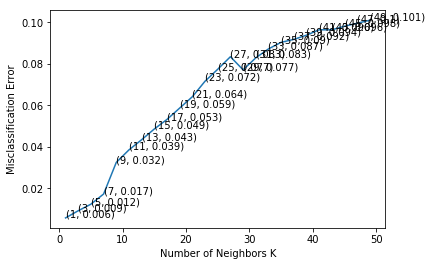

the misclassification error for each k value is :  [0.006 0.009 0.012 0.017 0.032 0.039 0.043 0.049 0.053 0.059 0.064 0.072
 0.077 0.083 0.077 0.083 0.087 0.09  0.092 0.094 0.096 0.096 0.098 0.1
 0.101]


In [28]:
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

In [29]:
# KNN with k = optimal_k

# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

# fitting the model
knn_optimal.fit(X_train, Y_train)

# predict the response
pred = knn_optimal.predict(X_test)

# evaluate accuracy
acc = accuracy_score(Y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 1 is 99.639856%


### Term Frequency– Inverse Document Frequency ( TF-IDF )

In [165]:
# Configuring ngram range from unigram to bigram
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(final_dataset['CleanedText'].values)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (5000, 151352)
the number of unique words including both unigrams and bigrams  151352


In [166]:
# Converting Sparse matric to array
final_tf_idf=final_tf_idf.toarray()
#tsne
start_time_code = time.time()
model = TSNE(n_components=2, random_state=0, perplexity=30)
tsne_data_tfidf = model.fit_transform(final_tf_idf)
end_time_code = time.time()
print ("Running Time for code execution " + str(end_time_code - start_time_code) + " secs")

Running Time for code execution 6420.043386220932 secs


In [167]:
tsne_data_tf = np.vstack((tsne_data_tfidf.T,label,Time)).T

In [168]:
#Saving tsne data into seperate file for further usecases.
tsne_tfidf_df = pd.DataFrame(data=tsne_data_tf, columns=("X", "Y", "Label","Date"))
tsne_tfidf_df.to_csv('/home/venkatasujit272/tsne_tfidf_data.csv')

In [169]:
# Aliasing the Score field values into Binary format
def partition(x):
    if x == 'negative':
        return 0.
    return 1.

# Aliasing the Score to String Format (Positive for Score > 3 & Negative for Score  < 3)

actualScore = tsne_tfidf_df['Label']
positiveNegative = actualScore.map(partition) 
tsne_tfidf_df['Label'] = positiveNegative

In [170]:
tsne_tfidf_df.head(1)

,X,Y,Label,Date
0,0.633459,-8.7365,1.0,1999-10-08


In [171]:
#Sorting the Dataframe with Date
tsne_tfidf_df.sort_values(by='Date',ascending=1)

,X,Y,Label,Date
0,0.633459,-8.7365,1.0,1999-10-08
28,0.621319,-8.71731,1.0,1999-10-25
377,-1.79879,-10.9841,1.0,1999-12-02
287,-2.03936,-12.3553,1.0,1999-12-06
376,-1.86981,-11.1863,1.0,2000-01-03
209,-2.02703,-10.426,1.0,2000-01-09
2540,-1.19717,-10.54,0.0,2000-01-19
198,4.47318,-11.9677,1.0,2000-01-24
224,-2.31892,-12.8517,1.0,2000-02-26
284,0.119211,-10.6952,1.0,2000-06-03


In [172]:
# create design matrix X and target vector y
X_tfidf = np.array(tsne_tfidf_df.iloc[:, 0:4]) # end index is exclusive
Y_tfidf = np.array(tsne_tfidf_df['Label']) # showing you two ways of indexing a pandas df

In [173]:
 # Timebasedf Split
tscv = TimeSeriesSplit(n_splits=5)
print(tscv)  

TimeSeriesSplit(n_splits=5)


In [174]:
# Splitting the Dataset into Train & Test Datasets
for train_index, test_index in tscv.split(X_tfidf):
   print("TRAIN:", train_index, "TEST:", test_index)
   X_tfidf_tr, X_tfidf_test = X[train_index], X[test_index]
   Y_tfidf_tr, Y_tfidf_test = Y[train_index], Y[test_index]

TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244

In [175]:
print(X_tfidf_tr.shape)
print(X_tfidf_test.shape)
print(Y_tfidf_tr.shape)
print(X_tfidf_test.shape)

(4167, 4)
(833, 4)
(4167,)
(833, 4)


In [176]:
# Splitting the Train dataset into Train & Cross Validation Dataset
for train_index, test_index in tscv.split(X_tfidf_tr):
   print("TRAIN:", train_index, "TEST:", test_index)
   X_tfidf_train, X_tfidf_cv = X[train_index], X[test_index]
   Y_tfidf_train, Y_tfidf_cv = Y[train_index], Y[test_index]

TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244

In [177]:
print(X_tfidf_train.shape)
print(X_tfidf_cv.shape)
print(X_tfidf_test.shape)

print(Y_tfidf_train.shape)
print(Y_tfidf_cv.shape)
print(Y_tfidf_test.shape)

(3473, 4)
(694, 4)
(833, 4)
(3473,)
(694,)
(833,)


In [178]:
# Removing Date variable from all the datasets
tfidf_X= []
for each in X_tfidf_train:
    tfidf_X.append(np.delete(each,3))
X_tfidf_train = np.asarray(tfidf_X)


tfidf_X_cv= []
for each in X_tfidf_cv:
    tfidf_X_cv.append(np.delete(each,3))
X_tfidf_cv = np.asarray(tfidf_X_cv)

tfidf_X_test= []
for each in X_tfidf_test:
    tfidf_X_test.append(np.delete(each,3))
X_tfidf_test = np.asarray(tfidf_X_test)

In [179]:
print(X_tfidf_train.shape)
print(X_tfidf_cv.shape)
print(X_tfidf_test.shape)

print(Y_tfidf_train.shape)
print(Y_tfidf_cv.shape)
print(Y_tfidf_test.shape)

(3473, 3)
(694, 3)
(833, 3)
(3473,)
(694,)
(833,)


In [180]:
# Finding the Test accuracy using Cross Validation Data Set
for i in range(1,30,2):
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i)

    # fitting the model on crossvalidation train
    knn.fit(X_tfidf_train, Y_tfidf_train)

    # predict the response on the crossvalidation train
    pred = knn.predict(X_tfidf_cv)

    # evaluate CV accuracy
    acc = accuracy_score(Y_tfidf_cv, pred, normalize=True) * float(100)
    print('\nCV accuracy for k = %d is %d%%' % (i, acc))
    
knn = KNeighborsClassifier(1)
knn.fit(X_tfidf_train,Y_tfidf_train)
pred = knn.predict(X_tfidf_test)
acc = accuracy_score(Y_tfidf_test, pred, normalize=True) * float(100)
print('\n****Test accuracy for k = 1 is %d%%' % (acc))


CV accuracy for k = 1 is 98%

CV accuracy for k = 3 is 98%

CV accuracy for k = 5 is 97%

CV accuracy for k = 7 is 96%

CV accuracy for k = 9 is 96%

CV accuracy for k = 11 is 96%

CV accuracy for k = 13 is 96%

CV accuracy for k = 15 is 95%

CV accuracy for k = 17 is 95%

CV accuracy for k = 19 is 94%

CV accuracy for k = 21 is 94%

CV accuracy for k = 23 is 93%

CV accuracy for k = 25 is 92%

CV accuracy for k = 27 is 89%

CV accuracy for k = 29 is 88%

****Test accuracy for k = 1 is 99%


In [181]:
# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

In [182]:
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_tfidf_train, Y_tfidf_train, cv=10)
    cv_scores.append(scores.mean())


The optimal number of neighbors is 1.


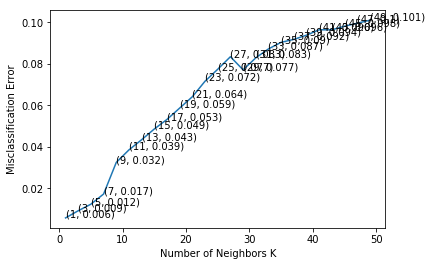

the misclassification error for each k value is :  [0.006 0.009 0.012 0.017 0.032 0.039 0.043 0.049 0.053 0.059 0.064 0.072
 0.077 0.083 0.077 0.083 0.087 0.09  0.092 0.094 0.096 0.096 0.098 0.1
 0.101]


In [183]:
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

In [184]:
# KNN with k = optimal_k

# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

# fitting the model
knn_optimal.fit(X_tfidf_train, Y_tfidf_train)

# predict the response
pred = knn_optimal.predict(X_tfidf_test)

# evaluate accuracy
acc = accuracy_score(Y_tfidf_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 1 is 99.639856%


## Average Word2Vec ( Avg W2V )

In [ ]:
# Word2Vec
#model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [76]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in final_dataset['CleanedText'].values:
    list_of_sent.append(sent.split())

In [77]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [78]:
# Printing Sample words
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3596
sample words  ['stare', 'thrip', 'made', 'teenag', 'mislead', 'support', 'televis', 'disc', 'decreas', 'peko', 'pound', 'preserv', 'die', 'canola', 'wash', 'difficulti', 'explain', 'relax', 'agar', 'guest', 'persian', 'primarili', 'king', 'second', 'indoor', 'beast', 'certifi', 'hundr', 'grab', 'overweight', 'immedi', 'come', 'puke', 'here', 'desper', 'pic', 'prudhomm', 'ignor', 'angl', 'aint', 'certain', 'mental', 'reject', 'drop', 'scream', 'work', 'grow', 'evil', 'sort', 'labrador']


In [79]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))

5000


In [80]:
#tsne
start_time_code = time.time()
model = TSNE(n_components=2, random_state=0, perplexity=30)
tsne_data_Aw2v = model.fit_transform(sent_vectors)
end_time_code = time.time()
print ("Running Time for code execution " + str(end_time_code - start_time_code) + " secs")

Running Time for code execution 119.21003150939941 secs


In [81]:
#Saving tsne data into seperate file for further usecases.
tsne_data_Aw2v = np.vstack((tsne_data_Aw2v.T,label,Time)).T
tsne_AW2V_df = pd.DataFrame(data=tsne_data_Aw2v, columns=("X", "Y", "Label","Date"))
tsne_AW2V_df.to_csv('/home/venkatasujit272/tsne_AW2V_data.csv')

In [106]:
# Aliasing the Score field values into Binary format
def partition(x):
    if x == 'negative':
        return 0.
    return 1.

# Aliasing the Score to String Format (Positive for Score > 3 & Negative for Score  < 3)

actualScore = tsne_AW2V_df['Label']
positiveNegative = actualScore.map(partition) 
tsne_AW2V_df['Label'] = positiveNegative

In [107]:
tsne_AW2V_df.head(1)

,X,Y,Label,Date
0,-9.86456,-6.63527,1.0,1999-10-08


In [108]:
#Sorting the Dataframe with Date to apply Timebased Split
tsne_AW2V_df.sort_values(by='Date',ascending=1)

,X,Y,Label,Date
0,-9.86456,-6.63527,1.0,1999-10-08
28,-7.92173,-3.97298,1.0,1999-10-25
377,4.77067,-6.03357,1.0,1999-12-02
287,-10.1318,-6.53944,1.0,1999-12-06
376,10.7702,1.09368,1.0,2000-01-03
209,9.03657,-2.81984,1.0,2000-01-09
2540,6.11455,-6.58935,0.0,2000-01-19
198,7.51311,-9.64076,1.0,2000-01-24
224,-5.14856,-7.64139,1.0,2000-02-26
284,6.9695,0.245181,1.0,2000-06-03


In [117]:
# create design matrix X and target vector y
X_AW2V = np.array(tsne_AW2V_df.iloc[:, 0:4]) # end index is exclusive
Y_AW2V = np.array(tsne_AW2V_df['Label']) # showing you two ways of indexing a pandas df

In [118]:
#Time based split
tscv = TimeSeriesSplit(n_splits=5)
print(tscv)  

TimeSeriesSplit(n_splits=5)


In [125]:
#Splitting the Dataset into Train set & Test set
for train_index, test_index in tscv.split(X_AW2V):
   print("TRAIN:", train_index, "TEST:", test_index)
   X_AW2V_tr, X_AW2V_test = X[train_index], X[test_index]
   Y_AW2V_tr, Y_AW2V_test = Y[train_index], Y[test_index]

TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244

In [126]:
print(X_AW2V_tr.shape)
print(X_AW2V_test.shape)
print(Y_AW2V_tr.shape)
print(Y_AW2V_test.shape)

(4167, 4)
(833, 4)
(4167,)
(833,)


In [127]:
# Splitting the Train dataset into Cross Validation & Train Datasets
for train_index, test_index in tscv.split(X_AW2V_tr):
   print("TRAIN:", train_index, "TEST:", test_index)
   X_AW2V_train, X_AW2V_cv = X[train_index], X[test_index]
   Y_AW2V_train, Y_AW2V_cv = Y[train_index], Y[test_index]

TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244

In [128]:
print(X_AW2V_train.shape)
print(X_AW2V_cv.shape)
print(X_AW2V_test.shape)

print(Y_AW2V_train.shape)
print(Y_AW2V_cv.shape)
print(Y_AW2V_test.shape)

(3473, 4)
(694, 4)
(833, 4)
(3473,)
(694,)
(833,)


In [129]:
# Removing the Date variable from the Data sets
AW2V_X= []
for each in X_AW2V_train:
    AW2V_X.append(np.delete(each,3))
X_AW2V_train = np.asarray(AW2V_X)


AW2V_X_cv= []
for each in X_AW2V_cv:
    AW2V_X_cv.append(np.delete(each,3))
X_AW2V_cv = np.asarray(AW2V_X_cv)

AW2V_X_test= []
for each in X_AW2V_test:
    AW2V_X_test.append(np.delete(each,3))
X_AW2V_test = np.asarray(AW2V_X_test)

In [130]:
print(X_AW2V_train.shape)
print(X_AW2V_cv.shape)
print(X_AW2V_test.shape)

print(Y_AW2V_train.shape)
print(Y_AW2V_cv.shape)
print(Y_AW2V_test.shape)

(3473, 3)
(694, 3)
(833, 3)
(3473,)
(694,)
(833,)


In [131]:
# Finding the Test accuracy using Cross Validation Data Set
for i in range(1,30,2):
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i)

    # fitting the model on crossvalidation train
    knn.fit(X_AW2V_train, Y_AW2V_train)

    # predict the response on the crossvalidation train
    pred = knn.predict(X_AW2V_cv)

    # evaluate CV accuracy
    acc = accuracy_score(Y_AW2V_cv, pred, normalize=True) * float(100)
    print('\nCV accuracy for k = %d is %d%%' % (i, acc))
    
knn = KNeighborsClassifier(1)
knn.fit(X_AW2V_train,Y_AW2V_train)
pred = knn.predict(X_AW2V_test)
acc = accuracy_score(Y_AW2V_test, pred, normalize=True) * float(100)
print('\n****Test accuracy for k = 1 is %d%%' % (acc))


CV accuracy for k = 1 is 98%

CV accuracy for k = 3 is 98%

CV accuracy for k = 5 is 97%

CV accuracy for k = 7 is 96%

CV accuracy for k = 9 is 96%

CV accuracy for k = 11 is 96%

CV accuracy for k = 13 is 96%

CV accuracy for k = 15 is 95%

CV accuracy for k = 17 is 95%

CV accuracy for k = 19 is 94%

CV accuracy for k = 21 is 94%

CV accuracy for k = 23 is 93%

CV accuracy for k = 25 is 92%

CV accuracy for k = 27 is 89%

CV accuracy for k = 29 is 88%

****Test accuracy for k = 1 is 99%


In [135]:
# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

In [136]:
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_AW2V_train, Y_AW2V_train, cv=10)
    cv_scores.append(scores.mean())


The optimal number of neighbors is 1.


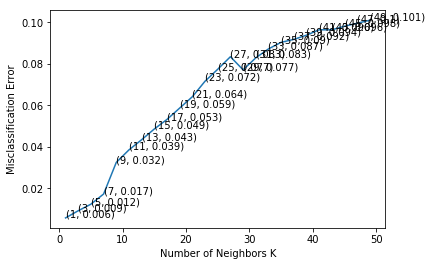

the misclassification error for each k value is :  [0.006 0.009 0.012 0.017 0.032 0.039 0.043 0.049 0.053 0.059 0.064 0.072
 0.077 0.083 0.077 0.083 0.087 0.09  0.092 0.094 0.096 0.096 0.098 0.1
 0.101]


In [137]:
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

In [138]:
# Finding Optimal K from a set of odd List of Integers
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

# fitting the model
knn_optimal.fit(X_AW2V_train, Y_AW2V_train)

# predict the response
pred = knn_optimal.predict(X_AW2V_test)

# evaluate accuracy
acc = accuracy_score(Y_AW2V_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 1 is 99.639856%


## TF-IDF - W2V 

In [82]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [101]:
#tsne
start_time_code = time.time()
model = TSNE(n_components=2, random_state=0, perplexity=30)
tsne_data_tfidf_Aw2v = model.fit_transform(tfidf_sent_vectors)
end_time_code = time.time()
print ("Running Time for code execution " + str(end_time_code - start_time_code) + " secs")

Running Time for code execution 102.52370500564575 secs


In [139]:
tsne_data_tfidf_Aw2v.shape

(5000, 2)

In [140]:
tsne_data_tf_Aw2v = np.vstack((tsne_data_tfidf_Aw2v.T,label,Time)).T

In [141]:
tsne_data_tf_Aw2v.shape

(5000, 4)

In [142]:
#Saving tsne data into seperate file for further usecases.
tsne_Tf_AW2V_df = pd.DataFrame(data=tsne_data_tf_Aw2v, columns=("X", "Y", "Label","Date"))
tsne_Tf_AW2V_df.to_csv('/home/venkatasujit272/tsne_Tf_AW2V_data.csv')

In [143]:
# Aliasing the Score field values into Binary format
def partition(x):
    if x == 'negative':
        return 0.
    return 1.

# Aliasing the Score to String Format (Positive for Score > 3 & Negative for Score  < 3)

actualScore = tsne_Tf_AW2V_df['Label']
positiveNegative = actualScore.map(partition) 
tsne_Tf_AW2V_df['Label'] = positiveNegative

In [144]:
tsne_Tf_AW2V_df.head(1)

,X,Y,Label,Date
0,-2.5246,-10.7039,1.0,1999-10-08


In [145]:
#Sorting the Dataframe with Date to apply Timebased Split
tsne_Tf_AW2V_df.sort_values(by='Date',ascending=1)

,X,Y,Label,Date
0,-2.5246,-10.7039,1.0,1999-10-08
28,-3.36253,-9.00849,1.0,1999-10-25
377,3.91971,-10.5973,1.0,1999-12-02
287,-4.60195,-11.4588,1.0,1999-12-06
376,1.9589,-2.21929,1.0,2000-01-03
209,2.61388,-2.75753,1.0,2000-01-09
2540,3.93277,-10.1787,0.0,2000-01-19
198,9.37026,-8.3316,1.0,2000-01-24
224,-7.84105,-2.76157,1.0,2000-02-26
284,8.18882,-3.9679,1.0,2000-06-03


In [146]:
# create design matrix X and target vector y
X_TW= np.array(tsne_Tf_AW2V_df.iloc[:, 0:4]) # end index is exclusive
Y_TW = np.array(tsne_Tf_AW2V_df['Label']) # showing you two ways of indexing a pandas df

In [147]:
tscv = TimeSeriesSplit(n_splits=5)
print(tscv)  

TimeSeriesSplit(n_splits=5)


In [148]:
#Splitting the Dataset into Train set & Test set
for train_index, test_index in tscv.split(X_TW):
   print("TRAIN:", train_index, "TEST:", test_index)
   X_TW_tr, X_TW_test = X[train_index], X[test_index]
   Y_TW_tr, Y_TW_test = Y[train_index], Y[test_index]

TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244

In [149]:
print(X_TW_tr.shape)
print(X_TW_test.shape)
print(Y_TW_tr.shape)
print(Y_TW_test.shape)

(4167, 4)
(833, 4)
(4167,)
(833,)


In [150]:
# Splitting the Train dataset into Cross Validation & Train Datasets
for train_index, test_index in tscv.split(X_TW_tr):
   print("TRAIN:", train_index, "TEST:", test_index)
   X_TW_train, X_TW_cv = X[train_index], X[test_index]
   Y_TW_train, Y_TW_cv = Y[train_index], Y[test_index]

TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244

In [151]:
print(X_TW_train.shape)
print(X_TW_cv.shape)
print(X_TW_test.shape)

print(Y_TW_train.shape)
print(Y_TW_cv.shape)
print(Y_TW_test.shape)

(3473, 4)
(694, 4)
(833, 4)
(3473,)
(694,)
(833,)


In [152]:
# Removing the Date variable from the Data sets
TW_X= []
for each in X_TW_train:
    TW_X.append(np.delete(each,3))
X_TW_train = np.asarray(TW_X)


TW_X_cv= []
for each in X_TW_cv:
    TW_X_cv.append(np.delete(each,3))
X_TW_cv = np.asarray(TW_X_cv)

TW_X_test= []
for each in X_TW_test:
    TW_X_test.append(np.delete(each,3))
X_TW_test = np.asarray(TW_X_test)

In [153]:
print(X_TW_train.shape)
print(X_TW_cv.shape)
print(X_TW_test.shape)

print(Y_TW_train.shape)
print(Y_TW_cv.shape)
print(Y_TW_test.shape)

(3473, 3)
(694, 3)
(833, 3)
(3473,)
(694,)
(833,)


In [154]:
# Finding the Test accuracy using Cross Validation Data Set
for i in range(1,30,2):
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i)

    # fitting the model on crossvalidation train
    knn.fit(X_TW_train, Y_TW_train)

    # predict the response on the crossvalidation train
    pred = knn.predict(X_TW_cv)

    # evaluate CV accuracy
    acc = accuracy_score(Y_TW_cv, pred, normalize=True) * float(100)
    print('\nCV accuracy for k = %d is %d%%' % (i, acc))
    
knn = KNeighborsClassifier(1)
knn.fit(X_TW_train,Y_TW_train)
pred = knn.predict(X_TW_test)
acc = accuracy_score(Y_TW_test, pred, normalize=True) * float(100)
print('\n****Test accuracy for k = 1 is %d%%' % (acc))


CV accuracy for k = 1 is 98%

CV accuracy for k = 3 is 98%

CV accuracy for k = 5 is 97%

CV accuracy for k = 7 is 96%

CV accuracy for k = 9 is 96%

CV accuracy for k = 11 is 96%

CV accuracy for k = 13 is 96%

CV accuracy for k = 15 is 95%

CV accuracy for k = 17 is 95%

CV accuracy for k = 19 is 94%

CV accuracy for k = 21 is 94%

CV accuracy for k = 23 is 93%

CV accuracy for k = 25 is 92%

CV accuracy for k = 27 is 89%

CV accuracy for k = 29 is 88%

****Test accuracy for k = 1 is 99%


In [155]:
# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

In [156]:
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_TW_train, Y_TW_train, cv=10)
    cv_scores.append(scores.mean())


The optimal number of neighbors is 1.


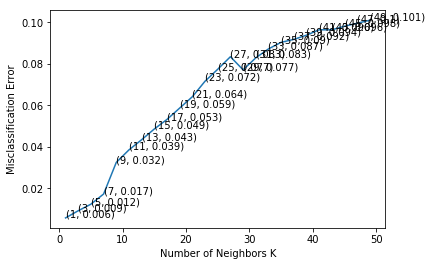

the misclassification error for each k value is :  [0.006 0.009 0.012 0.017 0.032 0.039 0.043 0.049 0.053 0.059 0.064 0.072
 0.077 0.083 0.077 0.083 0.087 0.09  0.092 0.094 0.096 0.096 0.098 0.1
 0.101]


In [157]:
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

In [158]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

# fitting the model
knn_optimal.fit(X_TW_train, Y_TW_train)

# predict the response
pred = knn_optimal.predict(X_TW_test)

# evaluate accuracy
acc = accuracy_score(Y_TW_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 1 is 99.639856%


 Conclusion:
        The Accuracy obtained by all different types of Doc2Vec conversion techniques ( BOW, TF-IDF, AW2V, TF_IDF W2V) are same i.e. 99.6%